In [3]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence, _generate_nd_derivative_relations, pde_to_ode_in_r, ode_in_r_to_x, recurrence_from_pde, process_recurrence_relation,ode_in_x_to_coeff_array, recurrence_from_coeff_array, shift_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [4]:
from sumpy.expansion.diff_op import DerivativeIdentifier, LinearPDESystemOperator
from immutabledict import immutabledict

In [5]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)
g = sp.Function('g')

In [6]:
ode_in_r, var, ode_order = pde_to_ode_in_r(laplace2d)
ode_in_x = ode_in_r_to_x(ode_in_r, var, ode_order).simplify()
ode_in_x_cleared = (ode_in_x * var[0]**(ode_order+1)).simplify()

In [7]:
s = sp.Function("s")
n = sp.Symbol('n')
sp.poly(recurrence_from_pde(laplace2d), s(n+2), s(n+1), s(n), s(n-1))

Poly((x0**3 + x0*x1**2)*(s(n + 2)) + (3*n*x0**2 + n*x1**2 + x0**2 - x1**2)*(s(n + 1)) + (3*n**2*x0 - n*x0)*(s(n)) + (n**3 - 2*n**2 + n)*(s(n - 1)), s(n + 2), s(n + 1), s(n), s(n - 1), domain='ZZ[x0,n,x1]')

In [8]:
def compute_derivatives_h2d(p, k=1.0):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz

In [9]:
num_derivs = 8
dervis_helm = compute_derivatives_h2d(num_derivs)
var = _make_sympy_vec("x", 2)

In [10]:
import time
timings = []

In [11]:
for i in range(num_derivs):
    start = time.time()
    dervis_helm[i].subs(var[0], np.random.rand()).subs(var[1], np.random.rand()).evalf()
    end = time.time()
    print(end-start)
    timings.append(end-start)

0.013469934463500977
0.04595208168029785
0.08181095123291016
0.17072415351867676
0.10633707046508789
0.22766709327697754
0.45116114616394043
1.0443289279937744


In [12]:
w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init, _, r = get_processed_and_shifted_recurrence(helmholtz2d)

In [13]:
s=sp.Function('s')
n=sp.Symbol('n')

check = []
x_coord = abs(np.random.rand()*1)  # noqa: NPY002
y_coord = abs(np.random.rand()*1)  # noqa: NPY002
coord_dict = {var[0]: x_coord, var[1]: y_coord}

subs_dict = {s(0): dervis_helm[0].subs(coord_dict).evalf(), s(1): dervis_helm[1].subs(coord_dict).evalf()}

assert n_init == 2
for i in range(n_init, num_derivs):
    start = time.time()
    print(r.subs(n, i))
    res = abs(r.subs(n, i).subs(subs_dict).subs(coord_dict).evalf())
    end = time.time()
    check.append(end-start)
    # pylint: disable-next=not-callable
    subs_dict[s(i)] = res

-x0**2*s(0)/(x0**2 + x1**2) + (x0**2 - x1**2)*s(1)/(x0**3 + x0*x1**2)
3*x0**2*s(0)/(x0**3 + x0*x1**2) + 4*x0**2*s(2)/(x0**3 + x0*x1**2) - (x0**2 + 2)*s(1)/(x0**2 + x1**2)
-(x0**2 + 10)*s(2)/(x0**2 + x1**2) + (6*x0**2 + 2)*s(1)/(x0**3 + x0*x1**2) + (7*x0**2 + x1**2)*s(3)/(x0**3 + x0*x1**2) - 6*s(0)/(x0**2 + x1**2)
-(x0**2 + 24)*s(3)/(x0**2 + x1**2) + (9*x0**2 + 12)*s(2)/(x0**3 + x0*x1**2) + (10*x0**2 + 2*x1**2)*s(4)/(x0**3 + x0*x1**2) + 6*s(0)/(x0**3 + x0*x1**2) - 18*s(1)/(x0**2 + x1**2)
-(x0**2 + 44)*s(4)/(x0**2 + x1**2) + (12*x0**2 + 36)*s(3)/(x0**3 + x0*x1**2) + (13*x0**2 + 3*x1**2)*s(5)/(x0**3 + x0*x1**2) + 24*s(1)/(x0**3 + x0*x1**2) - 36*s(2)/(x0**2 + x1**2)
-(x0**2 + 70)*s(5)/(x0**2 + x1**2) + (15*x0**2 + 80)*s(4)/(x0**3 + x0*x1**2) + (16*x0**2 + 4*x1**2)*s(6)/(x0**3 + x0*x1**2) + 60*s(2)/(x0**3 + x0*x1**2) - 60*s(3)/(x0**2 + x1**2)


Text(0.5, 1.0, 'Helmholtz 2D')

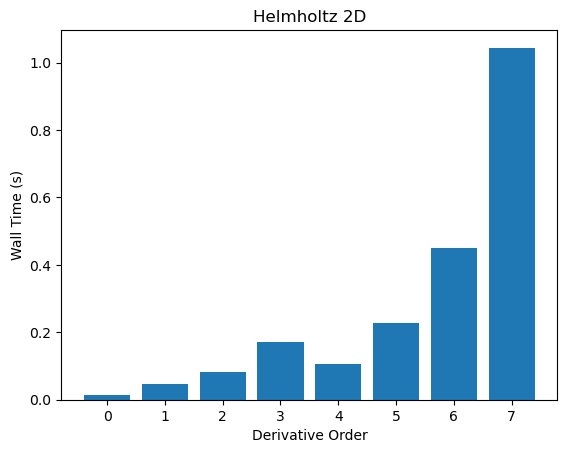

In [14]:
plt.bar([i for i in range(0, num_derivs)], timings)
plt.ylabel('Wall Time (s)')
plt.xlabel('Derivative Order')
plt.title("Helmholtz 2D")

Text(0.5, 1.0, 'Helmholtz 2D')

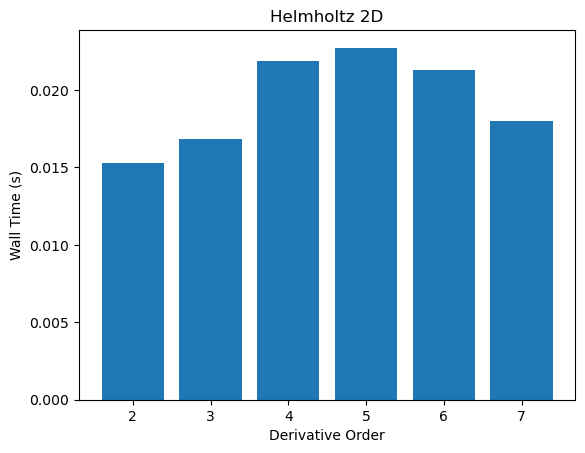

In [15]:
plt.bar([i for i in range(n_init, num_derivs)], check)
plt.ylabel('Wall Time (s)')
plt.xlabel('Derivative Order')
plt.title("Helmholtz 2D")

In [16]:
w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w
n_init, _, recurrence_helm = get_processed_and_shifted_recurrence(helmholtz2d)
derivs_helm = dervis_helm
n = sp.symbols("n")
s = sp.Function("s")

In [17]:
recurrence_helm = recurrence_helm.subs(s, g)

In [18]:
derivs_helm[2]

0.25*I*(0.25*x0**2*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(0, 1.0*sqrt(x0**2 + x1**2)) + hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2) - 0.5*x0**2*(hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(3/2) + (0.5*hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - 0.5*hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/sqrt(x0**2 + x1**2))

In [24]:
derivs_helm[4]

-0.25*I*(-2.25*x0**4*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(0, 1.0*sqrt(x0**2 + x1**2)) + hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**3 + 7.5*x0**4*(hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(7/2) + 2.25*x0**2*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(0, 1.0*sqrt(x0**2 + x1**2)) + hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**2 + 1.0*x0**2*(0.25*x0**2*(hankel1(-3, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) + hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**2 - 0.25*x0**2*(hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(1, 1.0*sqrt(x0**2 + x1**2)) + hankel1(3, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**2 - 0.75*x0**2*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - hankel1(0, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(5/2) + 0.75*x0**2*(hankel1(0, 1.0*sqrt(x0**2 + x1**2)) - hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(5/2) - (0.25*hankel1(-3, 1.0*sqrt(x0**2 + x1**2)) - 

In [ ]:
derivs_helm[7]

0.25*I*x0*(1417.5*x0**6*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(0, 1.0*sqrt(x0**2 + x1**2)) + hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**6 - 5197.5*x0**6*(hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(13/2) - 2362.5*x0**4*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(0, 1.0*sqrt(x0**2 + x1**2)) + hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**5 - 300.0*x0**4*(0.25*x0**2*(hankel1(-3, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) + hankel1(1, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**2 - 0.25*x0**2*(hankel1(-1, 1.0*sqrt(x0**2 + x1**2)) - 2*hankel1(1, 1.0*sqrt(x0**2 + x1**2)) + hankel1(3, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**2 - 0.75*x0**2*(hankel1(-2, 1.0*sqrt(x0**2 + x1**2)) - hankel1(0, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(5/2) + 0.75*x0**2*(hankel1(0, 1.0*sqrt(x0**2 + x1**2)) - hankel1(2, 1.0*sqrt(x0**2 + x1**2)))/(x0**2 + x1**2)**(5/2) - (0.25*hankel1(-3, 1.0*sqrt(x0**2 +

In [20]:
recurrence_helm.subs(n, 3)

3*x0**2*g(0)/(x0**3 + x0*x1**2) + 4*x0**2*g(2)/(x0**3 + x0*x1**2) - (x0**2 + 2)*g(1)/(x0**2 + x1**2)

In [21]:
recurrence_helm.subs(n, 4)

-(x0**2 + 10)*g(2)/(x0**2 + x1**2) + (6*x0**2 + 2)*g(1)/(x0**3 + x0*x1**2) + (7*x0**2 + x1**2)*g(3)/(x0**3 + x0*x1**2) - 6*g(0)/(x0**2 + x1**2)

In [23]:
recurrence_helm.subs(n, 2)

-x0**2*g(0)/(x0**2 + x1**2) + (x0**2 - x1**2)*g(1)/(x0**3 + x0*x1**2)

In [ ]:
import sympy as sp
G = sp.Function("G")
v_1 = sp.Symbol('v_1')
v_2 = sp.Symbol("v_2")
v_3 = sp.Symbol("v_3")
x_1 = sp.Symbol("x_1")
x_2 = sp.Symbol("x_2")
x_3 = sp.Symbol("x_3")
t = sp.Symbol("t")

In [ ]:
sp.diff(G(x_1+v_1*t,x_2+v_2*t,x_3+v_3*t), t, 1).subs(t,0)

v_1*Subs(Derivative(G(_xi_1, x_2, x_3), _xi_1), _xi_1, x_1) + v_2*Subs(Derivative(G(x_1, _xi_2, x_3), _xi_2), _xi_2, x_2) + v_3*Subs(Derivative(G(x_1, x_2, _xi_3), _xi_3), _xi_3, x_3)

In [ ]:
sp.diff(G(x_1+v_1*t,x_2,x_3), t, 1).subs(t, 0)

v_1*Subs(Derivative(G(_xi_1, x_2, x_3), _xi_1), _xi_1, x_1)

In [ ]:
G(x_1+v_1*t,x_2+v_2*t,x_3+v_3*t)

G(t*v_1 + x_1, t*v_2 + x_2, t*v_3 + x_3)

In [ ]:
sp.diff(G(x_1+v_1*t,x_2+v_2*t,x_3+v_3*t), t, 2).subs(t, 0)

v_1*(v_1*Subs(Derivative(G(_xi_1, x_2, x_3), (_xi_1, 2)), _xi_1, x_1) + v_2*Subs(Derivative(G(_t*v_1 + x_1, _xi_2, x_3), _xi_2, _t*v_1 + x_1), _xi_2, x_2) + v_3*Subs(Derivative(G(_t*v_1 + x_1, x_2, _xi_3), _xi_3, _t*v_1 + x_1), _xi_3, x_3)) + v_2*(v_1*Subs(Derivative(G(_xi_1, _t*v_2 + x_2, x_3), _xi_1, _t*v_2 + x_2), _xi_1, x_1) + v_2*Subs(Derivative(G(x_1, _xi_2, x_3), (_xi_2, 2)), _xi_2, x_2) + v_3*Subs(Derivative(G(x_1, _t*v_2 + x_2, _xi_3), _xi_3, _t*v_2 + x_2), _xi_3, x_3)) + v_3*(v_1*Subs(Derivative(G(_xi_1, x_2, _t*v_3 + x_3), _xi_1, _t*v_3 + x_3), _xi_1, x_1) + v_2*Subs(Derivative(G(x_1, _xi_2, _t*v_3 + x_3), _xi_2, _t*v_3 + x_3), _xi_2, x_2) + v_3*Subs(Derivative(G(x_1, x_2, _xi_3), (_xi_3, 2)), _xi_3, x_3))

In [ ]:
sp.diff(G(x_1+v_1*t,x_2,x_3), t, 2).subs(t, 0)

v_1**2*Subs(Derivative(G(_xi_1, x_2, x_3), (_xi_1, 2)), _xi_1, x_1)